In [171]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.utils.data as data_utils


In [172]:
df = pd.read_csv("~/Desktop/CI Final Proj/Causal-Inference-Project/train2.txt",
                     header=0, sep=" ")


In [173]:
df

,swimDistance,rideDistance,winPoints,killPoints,matchDuration,weaponsAcquired,boosts,walkDistance
1,76.84,1228.0000,1462,986,1886,6,1,2050.0
2,4.39,4496.0000,1561,1329,1844,7,4,3365.0
3,16.03,0.0064,1563,1226,1441,7,0,3639.0
4,80.55,619.6000,1505,1318,1382,3,7,3086.0
5,20.19,1753.0000,1461,1087,1902,3,4,2280.0
...,...,...,...,...,...,...,...,...
6724,141.40,372.2000,1505,1018,1354,6,2,3528.0
6725,24.02,1867.0000,1617,1304,1822,6,0,2763.0
6726,67.82,214.2000,1516,1066,1896,0,0,121.9
6727,10.40,1913.0000,1423,996,1782,8,2,3938.0


In [174]:
model_mlp = nn.Sequential(
                nn.Linear(7, 128),
                nn.ReLU(),
                #nn.Linear(64, 128),
                #nn.ReLU(),
                nn.Linear(128, 32),
                nn.ReLU(),
                #nn.Linear(64, 32),
                #nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 1),
)

In [175]:
print(model_mlp)

Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=1, bias=True)
)


In [189]:
# Creating np arrays
target = df['walkDistance'].values
features = df.iloc[:,0:7].values

# Passing to DataLoader
data = data_utils.TensorDataset(torch.Tensor(features), torch.Tensor(target),)
train_data, test_data = data_utils.random_split(data, [6000, len(target)-6000])
train_loader = data_utils.DataLoader(train_data, batch_size=632, shuffle=True)
test_loader = data_utils.DataLoader(test_data, batch_size=32, shuffle=False)



In [177]:
df.shape

(6728, 8)

In [178]:
# create your optimizer
optimizer = optim.SGD(model_mlp.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.6)
criterion = nn.MSELoss()
epochs=400
device=torch.device("cpu")

In [190]:
model_mlp = model_mlp.to(device)
train_l = []
test_l = []
for _ in range(epochs):
    total_loss = 0.0
    model_mlp.train()
    for fea, targ in train_loader:
        
        fea = fea.to(device)
        targ = targ.to(device)
        #print(fea, targ)
        optimizer.zero_grad()
        outputs = model_mlp(fea).view(-1)
        #print(fea.size(), targ.size(), outputs.size())
        loss = criterion(outputs, targ)
        loss.backward()

        nn.utils.clip_grad_norm_(model_mlp.parameters(), 10)
        optimizer.step()
        #print(target, outputs)

        total_loss += loss.item()*fea.size(0)
    
    #print(f"train epoch loss: {total_loss/len(train_loader.dataset)}")
    train_l.append(total_loss/len(train_loader.dataset))

    model_mlp.eval()
    total_loss = 0.0
    for fea, targ in test_loader:
        fea = fea.to(device)
        targ = targ.to(device)
        outputs = model_mlp(fea).view(-1)
        loss2 = criterion(outputs, targ)
 
        total_loss += loss2.item()*fea.size(0)

    #print(f"test epoch loss: {total_loss/len(test_loader.dataset)}")
    test_l.append(total_loss/len(test_loader.dataset))

    scheduler.step()
    


In [191]:
outputs

tensor([2180.8035, 1936.3199, 1487.4066, 3328.1887, 1785.0059, 3020.5430,
        1893.6500, 2804.1160, 1789.9668, 2019.7899, 1582.1713, 1824.7512,
        1872.3176, 2335.4717, 2860.9614, 3458.7566, 2465.1870, 2627.3521,
        2875.3088, 2917.5881, 2024.7617, 2763.6274, 3493.3821, 2882.5776],
       grad_fn=<ViewBackward0>)

In [192]:
target

array([2050. , 3365. , 3639. , ...,  121.9, 3938. , 2184. ])

In [182]:
sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)

5697

In [187]:
outputs

tensor([3160.3225, 3528.2749, 2207.6387, 1971.2952, 5066.0044, 1854.6267,
        3038.5320, 2320.0178, 2995.0820, 2092.6091, 1683.5736, 2785.2534,
        3444.6956, 2055.5273, 2783.6892, 1866.8429, 4681.4150, 1884.9951,
        2807.5095, 2707.5310, 2016.5957, 4200.8340, 2111.4316, 1829.5536,
        1831.5734, 2929.4033, 1957.4291, 2997.7002], grad_fn=<ViewBackward0>)

In [188]:
target

array([2050. , 3365. , 3639. , ...,  121.9, 3938. , 2184. ])

<AxesSubplot: >

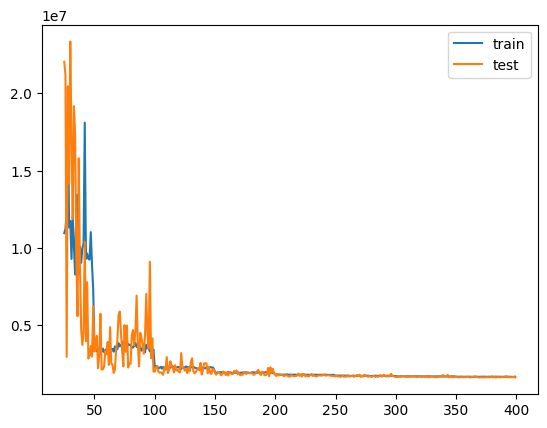

In [183]:
pp = pd.DataFrame({"train":train_l, "test":test_l})
pp.iloc[25:,].plot()

In [186]:
test_l[-1]

1632940.4100274725